In this notebook, I will extract the time and courts of the citation links.

In [1]:
import os
import time
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [2]:
case_df = pd.read_csv('data/case_df.csv')
case_df.head()

opinion_id  cluster_id  level  json_id   
0      458753      458753      0        0  \
1     2621442     2621442      0        1   
2      491523      491523      0        2   
3     4849283     4849283      0        3   
4     1802247     1802247      0        4   

                                        cite_towards  date_filed   
0  ['104943', '106170', '107729', '109311', '1095...  1985-10-03  \
1  ['1266434', '1370825', '2588725', '2598742', '...  2003-01-21   
2  ['303703', '313605', '328125', '394145', '4475...  1987-06-10   
3                                        ['4652295']  2021-01-19   
4  ['105857', '108608', '109881', '111620', '1117...  1993-07-22   

   citation_count  docket_id   court_id  
0              87     515918        ca9  
1               3      82634  coloctapp  
2              42     807664        ca7  
3               1   33310655   nyappdiv  
4               1    1376493       gand

In [3]:
cite_towards = [eval(item) for item in case_df['cite_towards']]

In [38]:
source_id, dest_id, year = [], [], []
for idx, row in case_df.iterrows():
    for item in cite_towards[idx]:
        source_id.append(row['opinion_id'])
        dest_id.append(int(item))
        year.append(row['date_filed'].split('-')[0])
        

In [27]:
link_df = pd.DataFrame({'source_id': source_id, 'dest_id': dest_id, 'year': year})
len(link_df)

418091

In [29]:
link_df['source_court_id'] = link_df['source_id'].apply(lambda x:opinion_to_court.get(x))
link_df['dest_court_id'] = link_df['dest_id'].apply(lambda x:opinion_to_court.get(x))

In [39]:
link_df['year'] = year

In [40]:
link_df[link_df['dest_court_id'].notna()]

source_id  dest_id  year source_court_id dest_court_id
0          458753   104943  1985             ca9        scotus
1          458753   106170  1985             ca9        scotus
2          458753   107729  1985             ca9        scotus
3          458753   109311  1985             ca9        scotus
4          458753   109561  1985             ca9        scotus
...           ...      ...   ...             ...           ...
418075     104442   103226  1947          scotus        scotus
418076     104442   103243  1947          scotus        scotus
418077     104442   103355  1947          scotus        scotus
418081     104442   104061  1947          scotus        scotus
418087     104442   104374  1947          scotus        scotus

[190838 rows x 5 columns]

In [41]:
link_df.to_csv('data/link_df_full.csv', index=False)

# Calculate Citation by year

In [12]:
case_df['year'] = case_df['date_filed'].apply(lambda k: int(k.split('-')[0]))
opinion_id2year = dict(zip(case_df['opinion_id'], case_df['year']))

In [4]:
# Calculate the distribution by year
link_df = pd.read_csv('data/link_df_full.csv')
link_df = link_df[link_df['dest_court_id'].notna()]

In [5]:
link_df

source_id  dest_id  year source_court_id dest_court_id
0          458753   104943  1985             ca9        scotus
1          458753   106170  1985             ca9        scotus
2          458753   107729  1985             ca9        scotus
3          458753   109311  1985             ca9        scotus
4          458753   109561  1985             ca9        scotus
...           ...      ...   ...             ...           ...
418075     104442   103226  1947          scotus        scotus
418076     104442   103243  1947          scotus        scotus
418077     104442   103355  1947          scotus        scotus
418081     104442   104061  1947          scotus        scotus
418087     104442   104374  1947          scotus        scotus

[190838 rows x 5 columns]

In [6]:
from collections import defaultdict
dest_year_count = defaultdict(lambda: defaultdict(int))

level_0_source_ids = set(case_df[case_df['level'] == 0]['opinion_id'])

In [7]:
for idx, row in link_df.iterrows():
    dest_year_count[row['year']][row['dest_id']] += 1

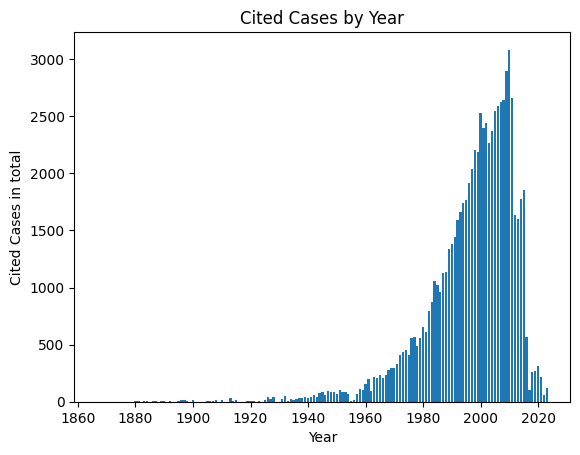

In [28]:
import matplotlib.pyplot as plt

year_cited_total = {}
for key, second_level in dest_year_count.items():
    year_cited_total[key] = len(second_level)

plt.bar(year_cited_total.keys(), year_cited_total.values())
plt.xlabel('Year')
plt.ylabel('Cited Cases in total')
plt.title('Cited Cases by Year')
plt.show()

8361


C:\Users\aruba\AppData\Local\Temp\ipykernel_29424\3549113498.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(case_count_total.values()))


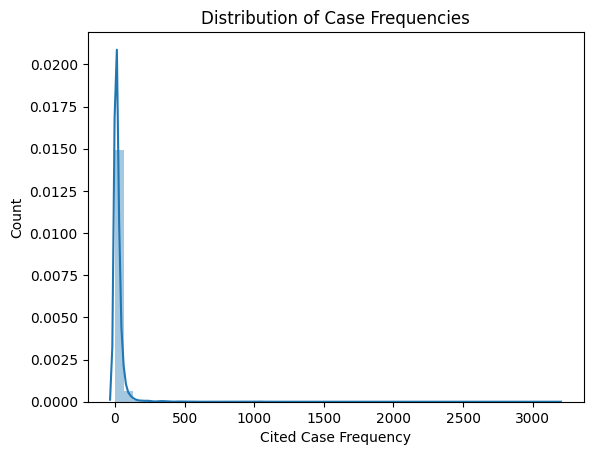

In [14]:
import seaborn as sns

case_count_total = defaultdict(int)
for second_level in dest_year_count.values():
    for item, count in second_level.items():
        case_count_total[item] += count

case_count_total = dict(sorted(case_count_total.items(), key=lambda item: item[1], reverse=True))
print(len(case_count_total))

sns.distplot(list(case_count_total.values()))
plt.xlabel('Cited Case Frequency')
plt.ylabel('Count')
plt.title('Distribution of Case Frequencies')

# Show the plot
plt.show()


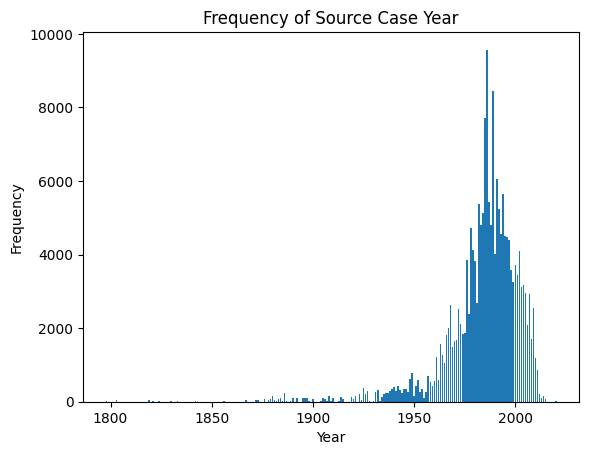

In [15]:
source_year_frequencies = defaultdict(int)

# Calculate year frequencies
for item_name, frequency in case_count_total.items():
    year = opinion_id2year[item_name]
    source_year_frequencies[year] += frequency

years = list(source_year_frequencies.keys())
frequencies = list(source_year_frequencies.values())

# Create the bar plot
plt.bar(years, frequencies)

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Source Case Year')

# Show the plot
plt.show()

In [16]:
# Now let's create the sparse vector of the cited case per year
# Probably need logarithm transformation to make it more precise
len_sparse_vector = len(case_count_total.keys())
opinion_to_position = dict()
for idx, key in enumerate(case_count_total.keys()):
    opinion_to_position[key] = idx

In [18]:
dest_year_count

defaultdict(<function __main__.<lambda>()>,
            {1985: defaultdict(int,
                         {104943: 19,
                          106170: 19,
                          107729: 16,
                          109311: 10,
                          109561: 14,
                          109881: 48,
                          110478: 35,
                          110900: 8,
                          110921: 2,
                          111397: 22,
                          111441: 26,
                          2609146: 1,
                          1615975: 3,
                          1667546: 1,
                          1668489: 2,
                          1680466: 1,
                          1700388: 1,
                          1728705: 1,
                          1767258: 1,
                          1842886: 1,
                          1956475: 2,
                          107200: 18,
                          110915: 8,
                          111378: 9,
            

In [65]:
vectors_by_year = dict()
for key, second_level in dest_year_count.items():
    year_vec = np.zeros(len_sparse_vector)
    for opinion, count in second_level.items():
        year_vec[opinion_to_position[opinion]] = count
    vectors_by_year[key] = year_vec

vectors_by_year = dict(sorted(vectors_by_year.items(), key=lambda item: item[0], reverse=False))

In [119]:
def log_transformation(vectors_by_year):
    log_vectors_by_year = dict()
    for key, vector in vectors_by_year.items():
        log_vectors_by_year[key] = np.log(vector + 1)
    return log_vectors_by_year
log_vectors_by_year = log_transformation(vectors_by_year)

In [120]:
log_vectors_by_year

{1867: array([0., 0., 0., ..., 0., 0., 0.]),
 1878: array([0., 0., 0., ..., 0., 0., 0.]),
 1880: array([0., 0., 0., ..., 0., 0., 0.]),
 1881: array([0., 0., 0., ..., 0., 0., 0.]),
 1882: array([0., 0., 0., ..., 0., 0., 0.]),
 1883: array([0., 0., 0., ..., 0., 0., 0.]),
 1884: array([0., 0., 0., ..., 0., 0., 0.]),
 1886: array([0., 0., 0., ..., 0., 0., 0.]),
 1887: array([0., 0., 0., ..., 0., 0., 0.]),
 1889: array([0., 0., 0., ..., 0., 0., 0.]),
 1890: array([0., 0., 0., ..., 0., 0., 0.]),
 1892: array([0., 0., 0., ..., 0., 0., 0.]),
 1895: array([0., 0., 0., ..., 0., 0., 0.]),
 1896: array([0., 0., 0., ..., 0., 0., 0.]),
 1897: array([0., 0., 0., ..., 0., 0., 0.]),
 1898: array([0., 0., 0., ..., 0., 0., 0.]),
 1900: array([0., 0., 0., ..., 0., 0., 0.]),
 1904: array([0., 0., 0., ..., 0., 0., 0.]),
 1905: array([0., 0., 0., ..., 0., 0., 0.]),
 1906: array([0., 0., 0., ..., 0., 0., 0.]),
 1907: array([0., 0., 0., ..., 0., 0., 0.]),
 1908: array([0., 0., 0., ..., 0., 0., 0.]),
 1909: arr

In [102]:
import scipy
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

def kl_divergence(X, Y, epsilon = 1e-10):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    p = p / np.sum(p)
    q = q / np.sum(q)
    p = np.clip(p, epsilon, 1 - epsilon)
    q = np.clip(q, epsilon, 1 - epsilon)
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X, Y, epsilon = 1e-10):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    f_obs = np.array(p)
    f_exp = np.array(q)
    f_exp += epsilon
    chi_sqr = np.sum(((f_obs - f_exp)**2) / f_exp)
    return chi_sqr # scipy.stats.chisquare(p, q).statistic

def Wasserstein_divergence(P, Q):
    try:
        return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
    except:
        return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [94]:
P = pd.DataFrame(vectors_by_year[1960], columns = ['frequency'])
Q = pd.DataFrame(vectors_by_year[1961], columns = ['frequency'])
# scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'])
kl_divergence(P, Q)

5.453817065541256

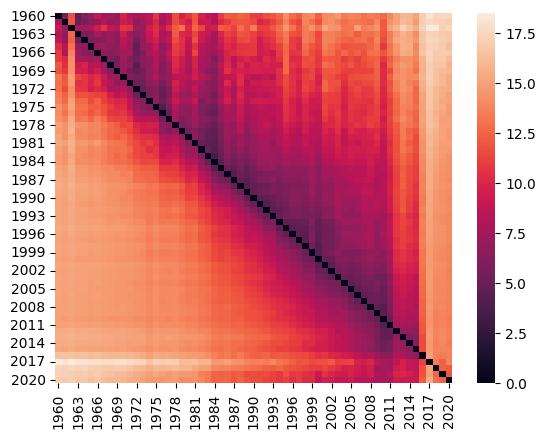

In [99]:
# Calculate the Interval By every year in KL divergence
year_x, year_y = list(range(1960, 2021)), list(range(1960, 2021))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(log_vectors_by_year[p], columns = ['frequency'])
        Q = pd.DataFrame(log_vectors_by_year[q], columns = ['frequency'])
        l.append(kl_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

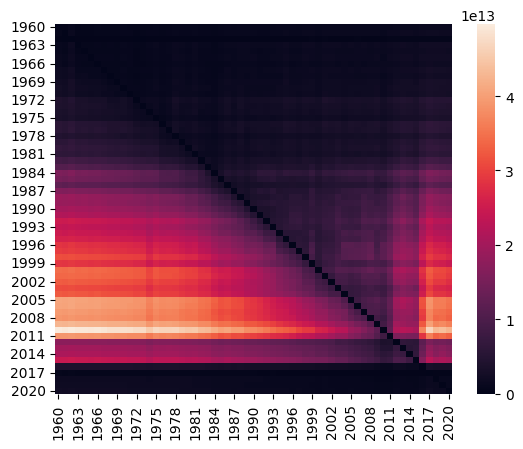

In [101]:
# Calculate the Interval By every year in Chi-square divergence
year_x, year_y = list(range(1960, 2021)), list(range(1960, 2021))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(log_vectors_by_year[p], columns = ['frequency'])
        Q = pd.DataFrame(log_vectors_by_year[q], columns = ['frequency'])
        l.append(chi2_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

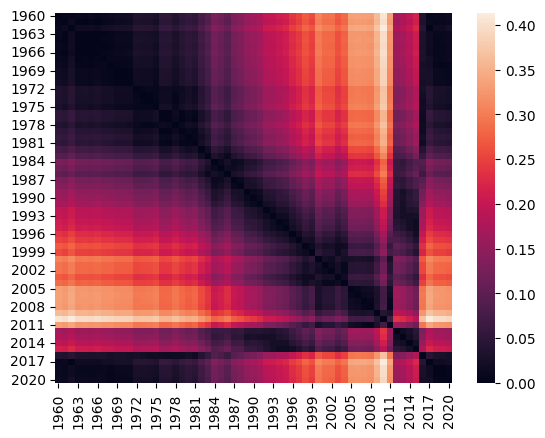

In [103]:
# Calculate the Interval By every year in Wasserstein divergence
year_x, year_y = list(range(1960, 2021)), list(range(1960, 2021))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(log_vectors_by_year[p], columns = ['frequency'])
        Q = pd.DataFrame(log_vectors_by_year[q], columns = ['frequency'])
        l.append(Wasserstein_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

Now we change the yearly interval length

In [108]:
N_interval = 5
five_year_interval = defaultdict()
min_year = 1960
max_year = 2020

In [117]:
for year in range(min_year, max_year , N_interval):
    five_year_interval[year] = np.zeros(len_sparse_vector)
    # Find the items whose years fall within the current interval
    items_in_interval = [item for item_year, item in vectors_by_year.items() if year <= item_year < year + N_interval]

    # Increment the counts for each item in the interval
    for item in items_in_interval:
        five_year_interval[year] += item

In [123]:
five_year_interval_log = log_transformation(five_year_interval)
five_year_interval_log

{1960: array([0.        , 0.        , 0.        , ..., 0.69314718, 0.        ,
        0.        ]),
 1965: array([0., 0., 0., ..., 0., 0., 0.]),
 1970: array([0.69314718, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 1975: array([0.        , 0.        , 2.77258872, ..., 0.        , 0.        ,
        0.        ]),
 1980: array([0.69314718, 3.66356165, 4.49980967, ..., 0.        , 0.        ,
        0.        ]),
 1985: array([3.55534806, 5.07517382, 5.38907173, ..., 0.        , 0.        ,
        0.        ]),
 1990: array([5.95324333, 5.66296048, 5.52942909, ..., 0.        , 0.        ,
        0.        ]),
 1995: array([6.23441073, 6.02344759, 5.74300319, ..., 0.        , 0.        ,
        0.        ]),
 2000: array([6.39191711, 6.02344759, 5.85220248, ..., 0.        , 0.        ,
        0.        ]),
 2005: array([6.72022016, 6.14632926, 6.09807428, ..., 0.        , 0.        ,
        0.        ]),
 2010: array([6.51619308, 5.82894562, 5.707110

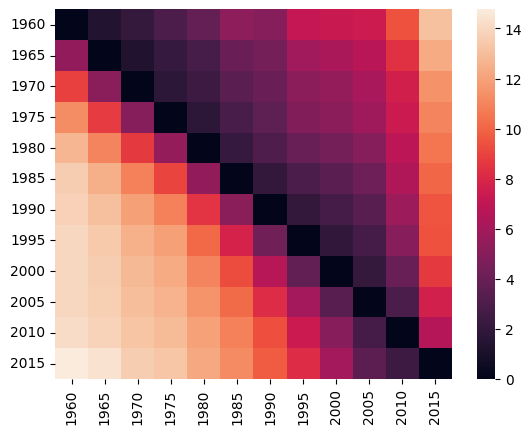

In [130]:
# Let's try the KL Divergence
year_x, year_y = list(range(min_year, max_year, 5)), list(range(min_year, max_year, 5))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(five_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(five_year_interval_log[q], columns = ['frequency'])
        l.append(kl_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

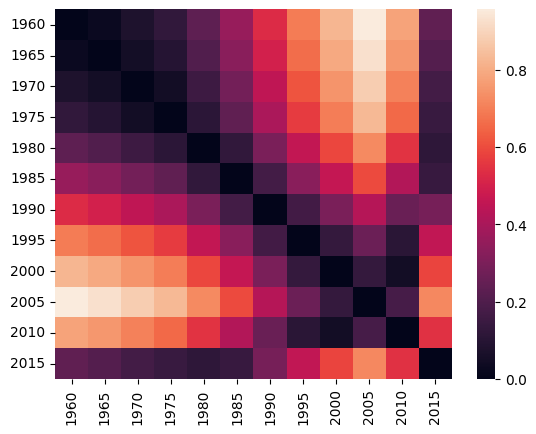

In [132]:
# Let's try the Wasserstein Divergence
year_x, year_y = list(range(min_year, max_year, 5)), list(range(min_year, max_year, 5))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(five_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(five_year_interval_log[q], columns = ['frequency'])
        l.append(Wasserstein_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

In [140]:
N_interval = 3
three_year_interval = defaultdict()

for year in range(min_year, max_year , N_interval):
    three_year_interval[year] = np.zeros(len_sparse_vector)
    # Find the items whose years fall within the current interval
    items_in_interval = [item for item_year, item in vectors_by_year.items() if year <= item_year < year + N_interval]

    # Increment the counts for each item in the interval
    for item in items_in_interval:
        three_year_interval[year] += item

three_year_interval_log = log_transformation(three_year_interval)

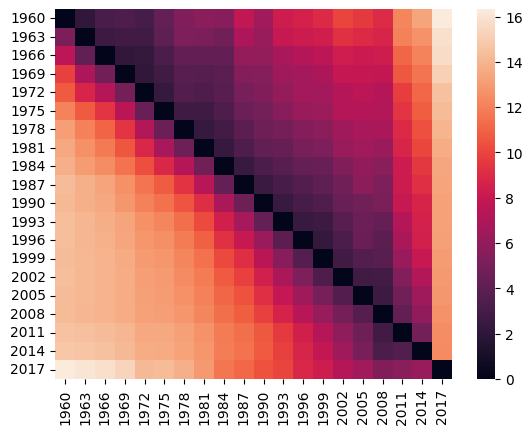

In [142]:
# Let's try the KL Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(kl_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

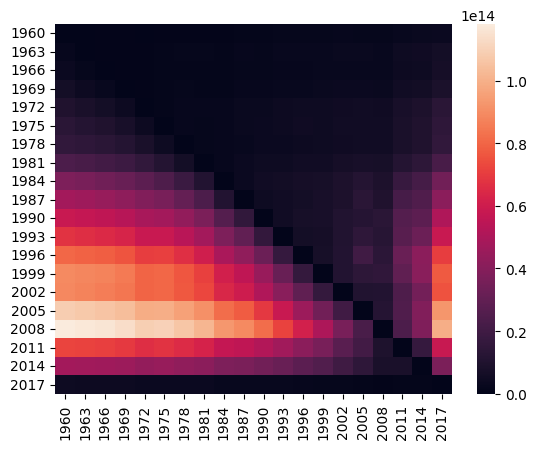

In [144]:
# Let's try the Chi2 Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(chi2_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

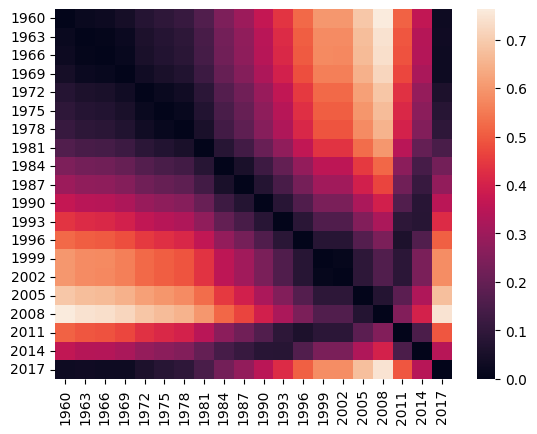

In [143]:
# Let's try the Wasserstein Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(Wasserstein_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

Let's try only keeping the top 1000 cited cases

In [145]:
def transform_vectors_by_year(dest_year_count, min_entry = 0, max_entry = len_sparse_vector):
    vectors_by_year = dict()
    for key, second_level in dest_year_count.items():
        year_vec = np.zeros(len_sparse_vector)
        for opinion, count in second_level.items():
            idx = opinion_to_position[opinion]
            if min_entry <= idx < max_entry:
                year_vec[idx] = count
        vectors_by_year[key] = year_vec

    vectors_by_year = dict(sorted(vectors_by_year.items(), key=lambda item: item[0], reverse=False))
    return vectors_by_year

In [154]:
def interval_transformation(vectors_by_year, N_interval, len_vec = len_sparse_vector):
    interval_count = defaultdict()

    for year in range(min_year, max_year , N_interval):
        interval_count[year] = np.zeros(len_vec)
        # Find the items whose years fall within the current interval
        items_in_interval = [item for item_year, item in vectors_by_year.items() if year <= item_year < year + N_interval]

        # Increment the counts for each item in the interval
        for item in items_in_interval:
            interval_count[year] += item[:len_vec]

    interval_count_log = log_transformation(interval_count)
    return interval_count, interval_count_log

In [146]:
vectors_by_year = transform_vectors_by_year(dest_year_count, 0, 1000)
three_year_interval, three_year_interval_log = interval_transformation(vectors_by_year, 3, 1000)

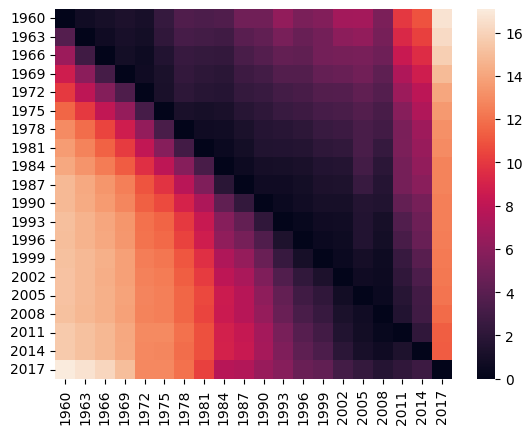

In [156]:
# Let's try the KL Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(kl_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

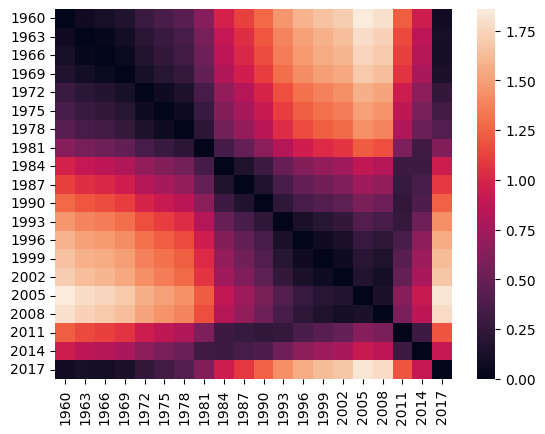

In [157]:
# Let's try the Wasserstein Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(Wasserstein_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

In [166]:
# Now let's try the Middle_range vectors
vectors_by_year = transform_vectors_by_year(dest_year_count, 500, 1500)
three_year_interval, three_year_interval_log = interval_transformation(vectors_by_year, 3, 1000)

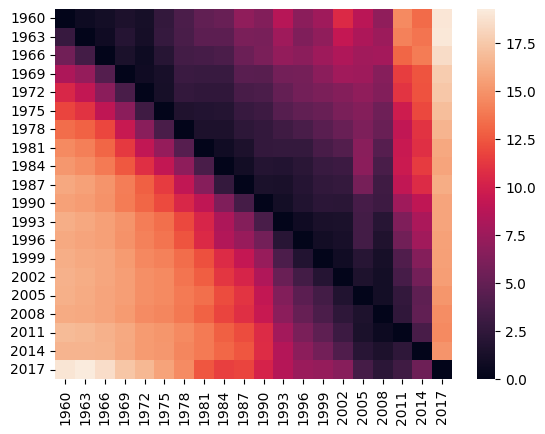

In [167]:
# Let's try the KL Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(kl_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

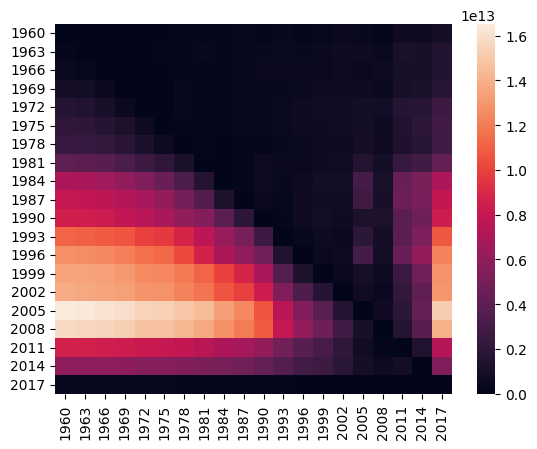

In [168]:
# Let's try the Chi2 Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(chi2_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

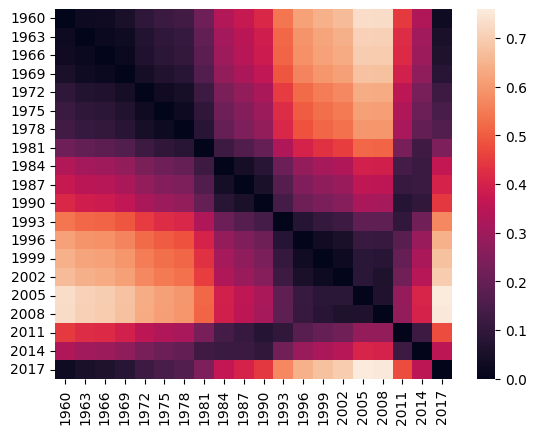

In [163]:
# Let's try the Wasserstein Divergence
year_x, year_y = list(range(min_year, max_year, N_interval)), list(range(min_year, max_year, N_interval))
L = []
for p in year_x:
    l = []
    for q in year_y:
        P = pd.DataFrame(three_year_interval_log[p], columns = ['frequency'])
        Q = pd.DataFrame(three_year_interval_log[q], columns = ['frequency'])
        l.append(Wasserstein_divergence(P, Q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = year_x, index = year_x)
ax = sns.heatmap(div)
plt.show()

# Cited Cases' Topics By Year

In [8]:
# Reload Data
dest_year_count

defaultdict(<function __main__.<lambda>()>,
            {1985: defaultdict(int,
                         {104943: 19,
                          106170: 19,
                          107729: 16,
                          109311: 10,
                          109561: 14,
                          109881: 48,
                          110478: 35,
                          110900: 8,
                          110921: 2,
                          111397: 22,
                          111441: 26,
                          2609146: 1,
                          1615975: 3,
                          1667546: 1,
                          1668489: 2,
                          1680466: 1,
                          1700388: 1,
                          1728705: 1,
                          1767258: 1,
                          1842886: 1,
                          1956475: 2,
                          107200: 18,
                          110915: 8,
                          111378: 9,
            

In [9]:
lda_prob = pd.read_json('data/fulldoc_lda_topic_prob.json')
lda_split = pd.read_json('data/splitted_lda_topic_prob.json')

In [24]:
topic_class = ['topic_{}'.format(i) for i in range(20)]
lda_split_prob = []
for name, group in lda_split.groupby('name'):
    opinion_id = {'opinion_id': name}
    outcome = dict(group[topic_class].mean())
    row = {**opinion_id, **outcome}
    lda_split_prob.append(row)

lda_split_prob = pd.DataFrame(lda_split_prob)

In [36]:
opinion_to_lda_prob = dict()
lda_prob_array = np.array(lda_prob.loc[:, lda_prob.columns[-20:]])

for idx, row in lda_prob.iterrows():
    opinion_to_lda_prob[row['name']] = lda_prob_array[idx]

In [31]:
def squeeze_year_into_interval(freq_dict, min_year, max_year, N_interval):
    result_dict = dict()
    for start_year in range(min_year, max_year , N_interval):
        combined_interval_dict = defaultdict(int)
        for specific_year in list(range(start_year, start_year + N_interval)):
            for obj_id, count in freq_dict.get(specific_year).items():
                combined_interval_dict[obj_id] += count

        result_dict[start_year] = combined_interval_dict
        
    return result_dict

In [39]:
N_interval = 5
five_year_interval = defaultdict()
min_year = 1960
max_year = 2020

In [52]:
five_year_squeezed = squeeze_year_into_interval(dest_year_count, min_year, max_year, 5)
three_year_squeezed = squeeze_year_into_interval(dest_year_count, min_year, max_year, 3)

#### Question: 
1. This vector is sparse. Do we need to add further weighting to the most-cited cases?
2. How can we handle the topic visualization (or quantification of change) in the splitted documents?  I don't think taking average is a good idea.

In [45]:
case_df[case_df['level']==0]

opinion_id  cluster_id  level  json_id   
0          458753      458753      0        0  \
1         2621442     2621442      0        1   
2          491523      491523      0        2   
3         4849283     4849283      0        3   
4         1802247     1802247      0        4   
...           ...         ...    ...      ...   
19222     2424823     2424823      0    19222   
19223     4613652     4613652      0    19223   
19224     2424827     2424827      0    19224   
19225     3383506     3383506      0    19225   
19226     6067205     6067205      0    19226   

                                            cite_towards  date_filed   
0      ['104943', '106170', '107729', '109311', '1095...  1985-10-03  \
1      ['1266434', '1370825', '2588725', '2598742', '...  2003-01-21   
2      ['303703', '313605', '328125', '394145', '4475...  1987-06-10   
3                                            ['4652295']  2021-01-19   
4      ['105857', '108608', '109881', '111620', '1117...  1993-07-22   
...                                                  ...         ...   
19222  ['19317', '74170', '105425', '106345', '107691...  2000-12-21   
19223                                                 []  2019-04-25   
19224  ['106761', '107336', '107717', '109214', '1095...  2001-01-02   
19225                                        ['1730302']  2002-01-30   
19226                                                 []  2013-06-27   

       citation_count  docket_id   court_id  
0                  87     515918        ca9  
1                   3      82634  coloctapp  
2                  42     807664        ca7  
3                   1   33310655   nyappdiv  
4                   1    1376493       gand  
...               ...        ...        ...  
19222               4    2296989        njd  
19223               0   14998059   nyappdiv  
19224               4    2297029        ctd  
19225               0    3255627      flaag  
19226               0   62427305   nyappdiv  

[19227 rows x 9 columns]

In [33]:
top_list = ['Topic {}'.format(i) for i in range(1,21)]

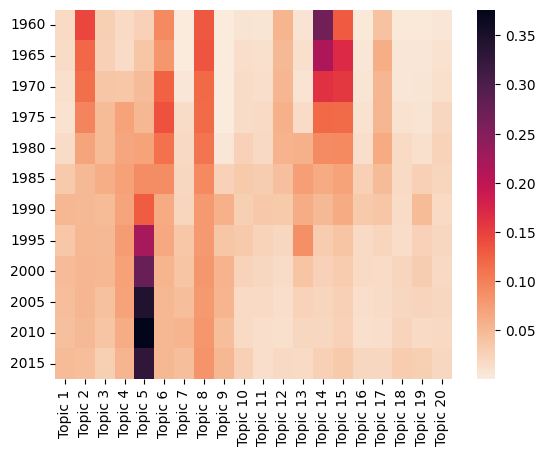

In [81]:
five_year_heatmap = []
years_label = []

for year, target_dict in five_year_squeezed.items():
    years_label.append(year)
    tot_cite = 0
    vec = np.zeros(20)
    for op_id, occurrences in target_dict.items():
        if op_id in opinion_to_lda_prob:
            tot_cite += occurrences
            vec += opinion_to_lda_prob.get(op_id) * occurrences
    vec = vec / tot_cite
    five_year_heatmap.append(vec)

five_year_heatmap = np.array(five_year_heatmap)
fig = plt.figure()
div = pd.DataFrame(five_year_heatmap, columns = top_list, index =  years_label)
ax = sns.heatmap(div, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.show()

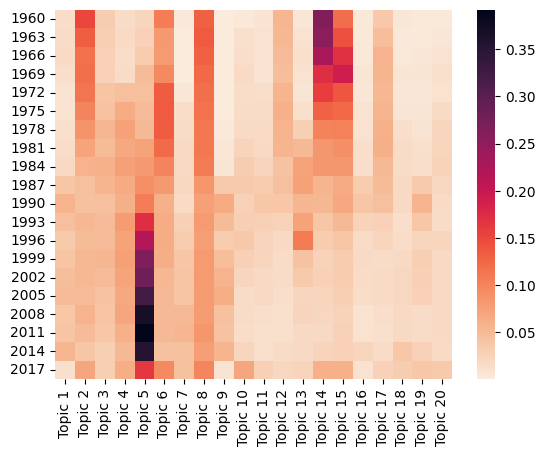

In [83]:
three_year_heatmap = []
years_label = []

for year, target_dict in three_year_squeezed.items():
    years_label.append(year)
    tot_cite = 0
    vec = np.zeros(20)
    for op_id, occurrences in target_dict.items():
        if op_id in opinion_to_lda_prob:
            tot_cite += occurrences
            vec += opinion_to_lda_prob.get(op_id) * occurrences
    vec = vec / tot_cite
    three_year_heatmap.append(vec)

three_year_heatmap = np.array(three_year_heatmap)
fig = plt.figure()
div = pd.DataFrame(three_year_heatmap, columns = top_list, index =  years_label)
ax = sns.heatmap(div, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.show()

# Splitted LDA

In [30]:
opinion_to_lda_prob = dict()
lda_prob_array = np.array(lda_split_prob.loc[:, lda_split_prob.columns[-20:]])

for idx, row in lda_split_prob.iterrows():
    opinion_to_lda_prob[row['opinion_id']] = lda_prob_array[idx]

In [39]:
N_interval = 5
five_year_interval = defaultdict()
min_year = 1950
max_year = 2020

In [40]:
five_year_squeezed = squeeze_year_into_interval(dest_year_count, min_year, max_year, 5)
three_year_squeezed = squeeze_year_into_interval(dest_year_count, min_year, max_year, 3)

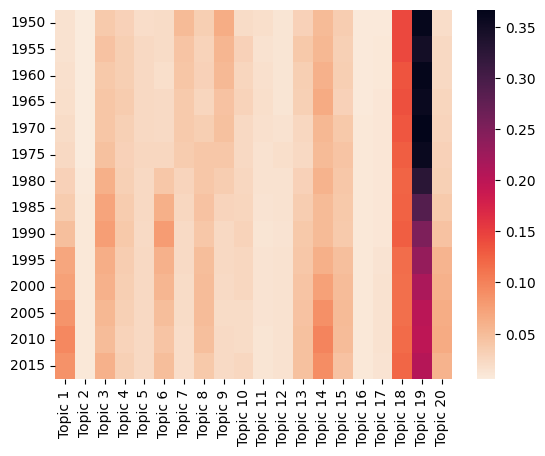

In [41]:
import seaborn as sns

five_year_heatmap = []
years_label = []

for year, target_dict in five_year_squeezed.items():
    years_label.append(year)
    tot_cite = 0
    vec = np.zeros(20)
    for op_id, occurrences in target_dict.items():
        if op_id in opinion_to_lda_prob:
            tot_cite += occurrences
            vec += opinion_to_lda_prob.get(op_id) * occurrences
    vec = vec / tot_cite
    five_year_heatmap.append(vec)

five_year_heatmap = np.array(five_year_heatmap)
fig = plt.figure()
div = pd.DataFrame(five_year_heatmap, columns = top_list, index =  years_label)
ax = sns.heatmap(div, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.show()

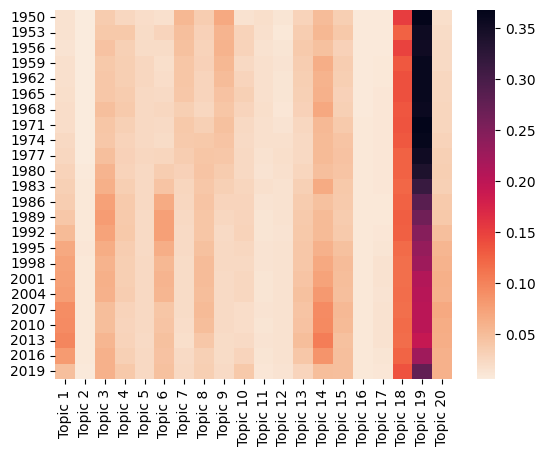

In [42]:
three_year_heatmap = []
years_label = []

for year, target_dict in three_year_squeezed.items():
    years_label.append(year)
    tot_cite = 0
    vec = np.zeros(20)
    for op_id, occurrences in target_dict.items():
        if op_id in opinion_to_lda_prob:
            tot_cite += occurrences
            vec += opinion_to_lda_prob.get(op_id) * occurrences
    vec = vec / tot_cite
    three_year_heatmap.append(vec)

three_year_heatmap = np.array(three_year_heatmap)
fig = plt.figure()
div = pd.DataFrame(three_year_heatmap, columns = top_list, index =  years_label)
ax = sns.heatmap(div, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.show()